In [6]:
import numpy as np
from numpy import array
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [48]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.H @ self.mu 
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.identity(self.mu.size)
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T
        
kf = KalmanFilter()
kf.hello = 3

# KF assimilation
def assimilate(y_t, H_t, mu, Sigma, Sigma_y_t):
    # Predict y to measure innovation
    y_hat = H_t @ mu 
    # Calculate Kalman gain
    K = Sigma @ H_t.T @ inv(H_t@Sigma@H_t.T + Sigma_y_t)
    # Update belief
    I = np.identity(mu.size)
    mu = mu + K @ (y_t - y_hat)
    Sigma = (I-K@H_t)@Sigma
    #print(mu)
    #print(Sigma)
    return mu, Sigma

In [49]:
# Initialize the Kalman Filter
kf = KalmanFilter()
# predict dynamics
dt = 1
kf.M = array([[1,dt],
      [0,1]])
# update dynamics
kf.H = array([
    [1,0]
])
# Create initial prior
kf.mu = array([[3],
                [4]])
kf.Sigma = array([
    [50,0],
    [0,50]
])
# noise of observations
kf.Sigma_y = None #added later

In [50]:
# Create observations
Sigma_y = array([
    [50,0],
    [0,1]
])
kf.Sigma_y = Sigma_y[0,0]
T = 30
x_truth = [array([[50],[2]])]
for t in range(1,T):
    x_truth.append(kf.M@x_truth[t-1])
x_obs = [xt + np.random.multivariate_normal([0,0], Sigma_y, 1).T for xt in x_truth]

In [52]:
# Assimilate over time
time = np.linspace(1,T,T)
pos_truth = [o[0] for o in x_truth]
pos_obs = [obs[0] for obs in x_obs]
mu_prior = []
mu_posterior = []
for t in range(T):
    mu_prior.append(kf.mu[0])
    # assimilation step
    kf.update(pos_obs[t])
    mu_posterior.append(kf.mu[0])
    # time dynamics for next iteration
    kf.predict()

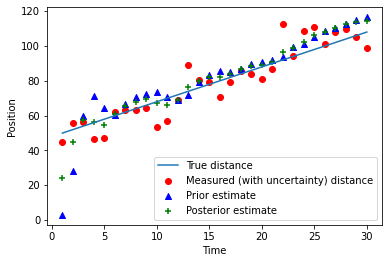

In [53]:
# Inspect
plot1 = plt.figure(1)
plt.plot(time, pos_truth)
plt.scatter(time, pos_obs, color="red")
plt.ylabel('Position')
plt.xlabel('Time')
plt.scatter(time, mu_prior, color="blue", marker="^")
plt.scatter(time, mu_posterior, color="green", marker="+")
plt.legend(['True distance', 
            'Measured (with uncertainty) distance', 
            'Prior estimate',
            'Posterior estimate'])
plt.show()